### Imports

In [1]:
import os
# os.environ['PATH'] = '/usr/local/cuda-11.6/bin:' + os.environ['PATH']
if 'notebooks' not in os.listdir(os.getcwd()):
    os.chdir('../') #changing directories so that output/gsplat_full etc. exists

from contextlib import redirect_stdout
from video_api import initialize_gaussians
from gaussian_renderer import render
import sys 
import torch 
from PIL import Image
import numpy as np

%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
import torchvision.transforms.functional as FT
from utils.mujoco_utils import compute_camera_extrinsic_matrix, compute_camera_intrinsic_matrix
from utils.mujoco_utils import get_canonical_pose, set_xml_light_params, find_non_collision_pose, save_robot_metadata, ControlRobot
import mujoco
from utils.graphics_utils import getWorld2View2, getProjectionMatrix, se3_to_SE3
from IPython.display import Image as IPImage
from moviepy import ImageSequenceClip
from scipy.spatial.transform import Rotation 
import cv2
from torchviz import make_dot
import pandas as pd
from skimage import measure

from torchvision import transforms

from notebooks.utils import Utils

from train_init_network import PoseNet, PoseNetTransformer


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Functions

### Initialization

In [2]:
torch.cuda.get_device_name(1)

'NVIDIA GeForce RTX 4090'

In [3]:
## ------ Initialize Gaussian Renderer ------ ##
sys.argv = ['']
gaussians, background_color, sample_cameras, kinematic_chain = initialize_gaussians(model_path='./output/LND_short', bg_color=[0, 0, 0])
pose = gaussians.get_xyz
w2e = torch.mean(gaussians._xyz, 0).clone().detach()

# with torch.no_grad():  # Ensure no gradient tracking for direct modification
    # gaussians._xyz[:] -= torch.mean(gaussians._xyz, 0)  # translation
# print(gaussians._xyz[:, 2])
print(w2e)
T_wt_homogeneous = torch.cat([w2e, torch.tensor([1.0], device='cuda:0')])
example_camera = sample_cameras[0]
P = example_camera.projection_matrix.to('cuda:0')
print(example_camera.world_view_transform)
print("P\n",P)
import math
tanfovx = math.tan(example_camera.FoVx * 0.5)
tanfovy = math.tan(example_camera.FoVy * 0.5)

focal_length_x = example_camera.image_width / (2 * tanfovx)
focal_length_y = example_camera.image_height / (2 * tanfovy)
K = torch.tensor(
    [
        [focal_length_x, 0, example_camera.image_width / 2.0, 0],
        [0, focal_length_y, example_camera.image_height / 2.0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ],
    device="cuda",
)
print("K:\n", K)
print(example_camera.get_camera_center())
# example_camera.image_height = 540
# example_camera.image_width = 960

Config file not found at
self.model_path ./output/LND_short
[Scene] Loading trained Gaussian model at iteration 60000
[Scene] Loading robot model from model path
tensor([-0.0002,  0.0003,  0.0142], device='cuda:0')
tensor([[-9.6126e-01,  1.7346e-01,  2.1421e-01,  0.0000e+00],
        [-2.7564e-01, -6.0494e-01, -7.4704e-01,  0.0000e+00],
        [-0.0000e+00, -7.7715e-01,  6.2932e-01,  0.0000e+00],
        [-6.4449e-18, -3.5715e-17,  1.9102e-01,  1.0000e+00]])
P
 tensor([[ 2.4328,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4328,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001,  1.0000],
        [ 0.0000,  0.0000, -0.0100,  0.0000]], device='cuda:0')
K:
 tensor([[311.3939,   0.0000, 128.0000,   0.0000],
        [  0.0000, 311.3939, 128.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0')
tensor([-0.0409,  0.1427, -0.1202])


/home/iulian/chole_ws/src/drrobot/scene/gaussian_model.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lrs = torch.load(os.path.join(os.path.dirname(path), 'lrs.pth'))

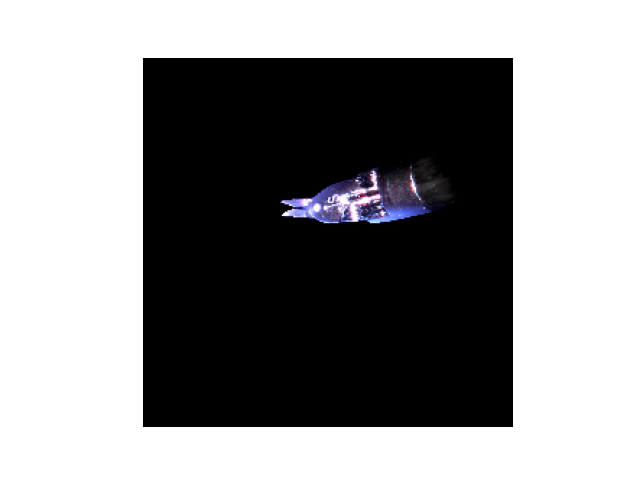

Reference image shape: torch.Size([3, 256, 256])
[[[ 9.89064342e-01  5.44573782e-02  1.37062470e-01  3.07877685e-03]
  [ 1.39508210e-01 -6.46936425e-01 -7.49673743e-01  9.87261910e-04]
  [ 4.78454375e-02  7.60596908e-01 -6.47459001e-01  6.02163764e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 7.10722244e-01 -6.30981114e-01 -3.11025281e-01  1.25901321e-04]
  [-4.79843281e-01 -1.11523964e-01 -8.70237227e-01 -6.27204049e-04]
  [ 5.14416483e-01  7.67740346e-01 -3.82034610e-01  1.59425768e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 3.96884448e-01 -6.49171046e-01  6.48891122e-01  1.08810142e-03]
  [ 7.39659681e-01 -1.92405709e-01 -6.44890377e-01  6.24887807e-05]
  [ 5.43494517e-01  7.35905562e-01  4.03802815e-01  5.88264410e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.83149096e-01  1.82672232e-01 -6.97922703e-03 -3.85223433e-03]
  [-8.99457683e-02  4.50148721e-01 -8.88412003e-01  1.6136811

In [4]:
## ------ Display Reference Image ------ ##
# original_image_path = "/home/iulian/chole_ws/src/drrobot/data/LND_pose_train/sample_11/image_1.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/drrobot/data/LND_pose_train/sample_11/image_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/surgripe/lnd_test/5.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/data/surgripe/lnd_test_segment_results/frame_4_id_1.jpg"  # Path to your reference image
original_image_path = "/home/iulian/chole_ws/src/sam2/data/lift_exp/lift_5/000150.jpg"  # Path to your reference image
reference_image_path = "/home/iulian/chole_ws/src/sam2/data/lift_exp/lift_5_segment_results/frame_149_id_1.jpg"  # Path to your reference image
fig = plt.figure()
data_dir = "/home/iulian/chole_ws/src/drrobot/data/LND_pose_train/sample_11"
object_poses = np.load(os.path.join(data_dir, "object_poses.npy"))



## read the image
original_image = Image.open(original_image_path).convert('RGB')
reference_image = Image.open(reference_image_path).convert('RGB')


## enhance brightness and contrast
enhanced_image = FT.adjust_brightness(reference_image, brightness_factor=3)  # Increase brightness by 20%
reference_image = FT.adjust_contrast(enhanced_image, contrast_factor=1.5)    # Increase contrast by 50%

## crop the image to be square
# reference_image = np.array(reference_image)[:540, :540]
reference_image = torch.tensor(np.array(reference_image) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
reference_image = Utils.pad_to_match_aspect(reference_image, 1.0)

# reference_image = augment(reference_image)

reference_image = F.interpolate(reference_image.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
reference_image_small = F.interpolate(reference_image.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False).squeeze(0)



plt.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
print("Reference image shape:", reference_image.shape)  # Expected: [3, H, W]

# Calculate target aspect ratio (reference image)
target_aspect_ratio = reference_image.shape[2] / reference_image.shape[1]

# Pad the rendered image to match the aspect ratio of the reference image
normalization_factor = torch.sum(reference_image ** 2).item()  # Sum of squared pixel values
print(object_poses)

In [5]:
def compute_initial_position(reference_image):
    # Create a mask where a pixel is non-black if the sum over channels is greater than zero.
    mask = (reference_image.sum(dim=0) > 0.1)
    
    # Count the number of non-black pixels.
    count = int(mask.sum().item())
    
    # If no non-black pixel is found, return count and a default center.
    if count == 0:
        return (None, None)
    
    # Get indices (row, col) of non-black pixels.
    indices = torch.nonzero(mask)  # shape: (num_nonblack, 2)
    
    # Compute the average center as the mean of row indices and column indices.
    avg_coords = indices.float().mean(dim=0)
    average_center = (avg_coords[0].item(), avg_coords[1].item())
    
    return average_center

average_center=compute_initial_position(reference_image)
print("average center:",average_center)

average center: (96.1822738647461, 161.5468292236328)


In [6]:
import copy
def grid_search_best_pose(average_center,example_camera, gaussians, background_color, reference_image, home_pose, divide_number_angle, divide_number_pos):

    # Create “master” copies of inputs that should remain unchanged across loops.
    # For tensors, use .clone(); for other mutable objects, use deepcopy.
    original_gaussians = copy.deepcopy(gaussians)
    original_background_color = copy.deepcopy(background_color)
    if torch.is_tensor(reference_image):
        original_reference_image = reference_image.clone()
    else:
        original_reference_image = copy.deepcopy(reference_image)
    
    best_final_loss = float('inf')
    best_initial_loss = float('inf')
    best_final_loss_index = None
    best_initial_loss_index = None

    num_combinations = divide_number_angle * (divide_number_pos ** 2)  # Total number of combinations
    for i in range(num_combinations):
        # Deepcopy the camera so that changes in one loop do not affect others.
        camera_copy = copy.deepcopy(example_camera)
        # Generate the initial pose using the provided index.
        T_rotated_torch = generate_initial_pose(camera_copy, divide_number_angle, divide_number_pos, i, average_center)
        camera_copy.world_view_transform = T_rotated_torch
        
        # Initialize parameters using copies.
        joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")
        world_view_transform_result = camera_copy.world_view_transform.clone().detach().to("cuda").requires_grad_(True)

        # Define learning rates.
        joint_pose_lr = 1e-3
        translation_lr = 1e-4

        # Create a fresh optimizer for this iteration.
        optimizer = torch.optim.Adam([
            {"params": joint_pose_result, "lr": joint_pose_lr},
            {"params": world_view_transform_result, "lr": translation_lr},
        ])

        num_iterations = 100
        loss_fn = torch.nn.MSELoss()
        video = []

        # Create fresh copies of the remaining inputs.
        gaussians_copy = copy.deepcopy(original_gaussians)
        background_color_copy = copy.deepcopy(original_background_color)
        if torch.is_tensor(original_reference_image):
            reference_image_copy = original_reference_image.clone()
        else:
            reference_image_copy = copy.deepcopy(original_reference_image)

        # Run the optimization function using the copied inputs.
        video, joint_pose_result_out, world_view_transform_result_out, pc, loss = \
            Utils.optimization_w2v(
                camera_copy, gaussians_copy, background_color_copy, reference_image_copy,
                loss_fn, optimizer, joint_pose_result, world_view_transform_result,
                num_iterations=num_iterations, plot=False
            )
        final_loss=loss[-1]
        initial_loss=loss[0]
        final_render = torch.clamp(render(camera_copy, gaussians_copy, background_color_copy)['render'], 0, 1)
        padded_rendered_image = Utils.pad_to_match_aspect(final_render, target_aspect_ratio)

        # Convert images for visualization
        rendered_image_np = padded_rendered_image.detach().permute(1, 2, 0).cpu().numpy()

        count, _=compute_nonblack_statistics(rendered_image_np)
        print(count)
        
        
        final_loss=final_loss/count
        initial_loss=initial_loss/count

        # Track the best losses along with the corresponding index.
        if final_loss < best_final_loss:
            best_final_loss = final_loss
            best_final_loss_index = i

        if initial_loss < best_initial_loss:
            best_initial_loss = initial_loss
            best_initial_loss_index = i

    return best_final_loss_index, best_initial_loss_index



def generate_initial_pose(example_camera, divide_number_angle, divide_number_pos, index, average_center):
    # Return the "index"th combination out of divide_number_angle * (divide_number_pos^2) total combinations.

    example_camera = sample_cameras[0]

    ## Customize camera parameters
    cam = mujoco.MjvCamera()
    mujoco.mjv_defaultCamera(cam)
    cam.distance = 0.1
    cam.azimuth = -50.0
    cam.elevation = -10
    cam.lookat = (0, 0, -0.0)
    w2v = compute_camera_extrinsic_matrix(cam)
    
    t0_up=min((average_center[1]-128)/256*0.08+0.01,0.04)
    t0_down=max((average_center[1]-128)/256*0.08-0.01,-0.04)
    t1_up=min((average_center[0]-128)/256*0.08+0.01,0.04)
    t1_down=max((average_center[0]-128)/256*0.08-0.01,-0.04)

    # Generate uniformly spaced values for theta, t[0] and t[1]
    thetas = np.linspace(-np.pi, np.pi, divide_number_angle)
    t0_vals = np.linspace(t0_down, t0_up, divide_number_pos)
    t1_vals = np.linspace(t1_down, t1_up, divide_number_pos)

    
    # Compute the combination indices:
    # Total combinations = divide_number_angle * (divide_number_pos)^2
    d_pos = divide_number_pos
    theta_idx = index // (d_pos * d_pos)
    remainder = index % (d_pos * d_pos)
    t0_idx = remainder // d_pos
    t1_idx = remainder % d_pos
    
    theta = thetas[theta_idx]

    ## Rotate the view using the computed theta
    R_z = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])

    R = w2v[:3, :3]
    t = w2v[:3, 3].copy()  # Make a copy to avoid modifying the original
    
    t[0] = t0_vals[t0_idx]
    t[1] = t1_vals[t1_idx]
    t[2] =0.1

    print(index, theta,t[0],t[1])
    # Apply the rotation
    R_rotated = R_z @ R  # Rotate the original rotation matrix
    t_rotated = t       # Use the modified translation vector

    # Combine back into a transformation matrix
    T_rotated = np.eye(4)
    T_rotated[:3, :3] = R_rotated
    T_rotated[:3, 3] = t_rotated

    T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype)\
                            .transpose(0, 1)\
                            .to(example_camera.data_device)
    return T_rotated_torch

def compute_nonblack_statistics(rendered_image_np):
    gray = rendered_image_np.sum(axis=2)
    
    # Create a mask for non-black pixels. A pixel is considered non-black if its sum > 0.
    mask = gray > 0.03
    
    # Count the number of non-black pixels.
    count = int(np.sum(mask))
    
    # If there are no non-black pixels, return count and a default center.
    if count == 0:
        return 0.00001, (None, None)
    
    # Get the indices (row, col) of non-black pixels.
    indices = np.argwhere(mask)
    
    # Compute the average coordinates (mean of rows and columns).
    average_center = indices.mean(axis=0)
    
    return count, (average_center[0], average_center[1])
    

In [7]:
model = PoseNetTransformer().to("cuda")
# model_params= torch.load("./output/LND_pose/pose_net_chkpnt29000.pth")
(model_params, trained_iter) = torch.load("./output/LND_pose_train_new_transformer/pose_net_chkpnt_155000.pth")

model.load_state_dict(model_params)

model.eval()  # Set to evaluation mode

output = model(reference_image_small.unsqueeze(0))
print(output)

## turn the output to homogenous transformation matrix
trans = output[0, :3]
rot = output[0, 3:]
print(rot)
rot = rot / torch.norm(rot)
## rot format: [qw, qx, qy, qz] -> [qx, qy, qz, qw]
# rot = torch.cat([rot[1:], rot[:1]]) 
print(rot)
rot = rot.cpu().detach().numpy()
## turn quaternion to rotation matrix
rot_matrix = Rotation.from_quat(rot).as_matrix()

pose = np.eye(4)
pose[:3, :3] = rot_matrix
# trans[0] += 0.02
trans[2] -= 0.08
pose[:3, 3] = trans.cpu().detach().numpy()

print(pose)

pose_rotation = pose[:3, :3]

## turn the rotation matrix to euler angles
euler = Rotation.from_matrix(pose_rotation).as_euler('xyz')

if np.abs(euler[0]) < np.pi/4 or np.abs(euler[0]) > 3 * np.pi/4:
    euler[2] = euler[0].copy()
    if euler[0] < 0:
        euler[0] = -np.pi/2
    else:
        euler[0] = np.pi/2

euler[2] = np.pi/2

print("euler", euler)
# euler[0] = -np.pi/2

pose_rotation_1 = Rotation.from_euler('xyz', euler).as_matrix()
pose[:3, :3] = pose_rotation_1


## ------ Configure Camera Parameters ------ ##
example_camera = sample_cameras[0]

## Customize camera parameters
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 0.1
cam.azimuth = -60.0
cam.elevation = -10
cam.lookat = (0,0,-0.0)
w2v = compute_camera_extrinsic_matrix(cam)

# ## rotate the view
# theta = -np.pi/2 #+ np.pi/12  # 90 degrees in radians
# R_z = np.array([
#     [np.cos(theta), -np.sin(theta), 0],
#     [np.sin(theta),  np.cos(theta), 0],
#     [0,              0,             1]
# ])
# R_x = np.array([
#     [1, 0, 0],
#     [0, np.cos(theta), -np.sin(theta)],
#     [0, np.sin(theta), np.cos(theta)]
# ])
# R_y = np.array([
#     [np.cos(theta), 0, np.sin(theta)],
#     [0, 1, 0],
#     [-np.sin(theta), 0, np.cos(theta)]
# ])

# R = pose[:3, :3]
# t = pose[:3, 3]

# # Apply translation
# # t[0] = -0.5
# # t[1] = 0.02
# t[0] += 0.01
# # t[1] += 0.01

# # Apply the rotation
# R_rotated = R_x @ R  # Rotate the original rotation matrix
# t_rotated = t  # Rotate the translation vector

# # Combine back into a transformation matrix
# T_rotated = np.eye(4)
# T_rotated[:3, :3] = R_rotated
# T_rotated[:3, 3] = t_rotated


home_pose = [0.0, 0.0, 0.0]
angle_divide_num=36
distance_divide_num=1
best_final_loss_index, best_initial_loss_index=grid_search_best_pose(average_center, example_camera, gaussians, background_color, reference_image, home_pose, angle_divide_num,distance_divide_num)
print("Best final loss index:", best_final_loss_index)
print("Best initial loss index:", best_initial_loss_index)


# T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)
#T_rotated_torch = torch.tensor(pose, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)
# T_rotated_torch = torch.tensor(object_poses[10], dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)
T_rotated_torch=generate_initial_pose(example_camera, angle_divide_num,distance_divide_num, best_final_loss_index, average_center)

example_camera.world_view_transform = T_rotated_torch
print("TWV:\n", example_camera.world_view_transform)


/home/iulian/miniforge3/envs/dr_2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/iulian/miniforge3/envs/dr_2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/iulian/miniforge3/envs/dr_2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_12837/1348763

tensor([[ 3.6608e-03, -6.0074e-04,  1.6015e-01, -2.2123e-01, -1.4262e-01,
          1.0518e-02, -9.6468e-01]], device='cuda:0', grad_fn=<CatBackward0>)
tensor([-0.2212, -0.1426,  0.0105, -0.9647], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-0.2212, -0.1426,  0.0105, -0.9647], device='cuda:0',
       grad_fn=<DivBackward0>)
[[ 9.59097138e-01  8.33991745e-02  2.70512951e-01  3.66084278e-03]
 [ 4.28114216e-02  9.01889749e-01 -4.29839577e-01 -6.00744039e-04]
 [-2.79821124e-01  4.23838952e-01  8.61429441e-01  8.01505297e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
euler [1.57079633 0.28360778 1.57079633]
0 -3.141592653589793 0.0004833841323852537 -0.019943039417266845


  0%|          | 0/100 [00:00<?, ?it/s]

[Cache] get_canonical_pose


/home/iulian/miniforge3/envs/dr_2/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
100%|██████████| 100/100 [00:03<00:00, 26.41it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0061, 0.0036, 0.0080, 0.0000],
        [0.0072, 0.0156, 0.0036, 0.0000],
        [0.0059, 0.0024, 0.0142, 0.0000],
        [0.0049, 0.0023, 0.0060, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1736
1 -2.962073073384662 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.61it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0064, 0.0065, 0.0098, 0.0000],
        [0.0060, 0.0157, 0.0051, 0.0000],
        [0.0038, 0.0018, 0.0144, 0.0000],
        [0.0085, 0.0029, 0.0046, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1795
2 -2.782553493179531 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 40.28it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0052, 0.0065, 0.0093, 0.0000],
        [0.0057, 0.0088, 0.0062, 0.0000],
        [0.0006, 0.0016, 0.0075, 0.0000],
        [0.0086, 0.0040, 0.0050, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1779
3 -2.6030339129744 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 41.98it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0050, 0.0087, 0.0113, 0.0000],
        [0.0078, 0.0070, 0.0085, 0.0000],
        [0.0037, 0.0032, 0.0047, 0.0000],
        [0.0089, 0.0059, 0.0059, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1777
4 -2.423514332769269 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 37.73it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0042, 0.0051, 0.0080, 0.0000],
        [0.0063, 0.0045, 0.0068, 0.0000],
        [0.0023, 0.0021, 0.0001, 0.0000],
        [0.0081, 0.0069, 0.0060, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1778
5 -2.243994752564138 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.41it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0047, 0.0103, 0.0079, 0.0000],
        [0.0061, 0.0126, 0.0031, 0.0000],
        [0.0016, 0.0024, 0.0161, 0.0000],
        [0.0079, 0.0078, 0.0061, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1799
6 -2.064475172359007 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0250, 0.0296, 0.0220, 0.0000],
        [0.0060, 0.0217, 0.0115, 0.0000],
        [0.0051, 0.0208, 0.0355, 0.0000],
        [0.0095, 0.0094, 0.0095, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1749
7 -1.8849555921538759 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 36.09it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0312, 0.0286, 0.0261, 0.0000],
        [0.0050, 0.0226, 0.0154, 0.0000],
        [0.0031, 0.0262, 0.0345, 0.0000],
        [0.0093, 0.0097, 0.0095, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1776
8 -1.7054360119487448 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.24it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0342, 0.0243, 0.0281, 0.0000],
        [0.0045, 0.0227, 0.0179, 0.0000],
        [0.0007, 0.0285, 0.0305, 0.0000],
        [0.0090, 0.0082, 0.0095, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1772
9 -1.5259164317436138 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 41.85it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0423, 0.0190, 0.0301, 0.0000],
        [0.0012, 0.0230, 0.0206, 0.0000],
        [0.0052, 0.0380, 0.0261, 0.0000],
        [0.0090, 0.0083, 0.0095, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1793
10 -1.3463968515384828 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.32it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0145, 0.0016, 0.0080, 0.0000],
        [0.0156, 0.0090, 0.0078, 0.0000],
        [0.0042, 0.0229, 0.0042, 0.0000],
        [0.0076, 0.0113, 0.0081, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1771
11 -1.1668772713333517 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 40.72it/s]


Difference between initial and final world_view_transform:
 tensor([[1.7308e-02, 5.9605e-08, 1.0712e-02, 0.0000e+00],
        [6.8678e-03, 1.1284e-02, 8.6008e-03, 0.0000e+00],
        [8.4739e-03, 1.9406e-02, 2.2389e-03, 0.0000e+00],
        [7.5923e-03, 1.0854e-02, 8.2957e-03, 0.0000e+00]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1781
12 -0.9873576911282207 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 37.64it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0156, 0.0017, 0.0108, 0.0000],
        [0.0060, 0.0137, 0.0093, 0.0000],
        [0.0113, 0.0177, 0.0004, 0.0000],
        [0.0062, 0.0102, 0.0083, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1787
13 -0.8078381109230897 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.49it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0147, 0.0008, 0.0133, 0.0000],
        [0.0004, 0.0156, 0.0116, 0.0000],
        [0.0125, 0.0136, 0.0010, 0.0000],
        [0.0057, 0.0100, 0.0083, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1780
14 -0.6283185307179586 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.02it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0115, 0.0016, 0.0114, 0.0000],
        [0.0009, 0.0176, 0.0111, 0.0000],
        [0.0140, 0.0117, 0.0059, 0.0000],
        [0.0059, 0.0098, 0.0085, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1778
15 -0.4487989505128276 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.75it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0127, 0.0030, 0.0135, 0.0000],
        [0.0047, 0.0173, 0.0127, 0.0000],
        [0.0158, 0.0088, 0.0048, 0.0000],
        [0.0052, 0.0097, 0.0085, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1784
16 -0.26927937030769655 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 37.97it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0091, 0.0006, 0.0110, 0.0000],
        [0.0060, 0.0171, 0.0118, 0.0000],
        [0.0128, 0.0055, 0.0100, 0.0000],
        [0.0057, 0.0097, 0.0087, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1797
17 -0.08975979010256552 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 37.81it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0072, 0.0033, 0.0085, 0.0000],
        [0.0066, 0.0227, 0.0117, 0.0000],
        [0.0142, 0.0048, 0.0184, 0.0000],
        [0.0055, 0.0102, 0.0088, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1778
18 0.08975979010256552 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 42.22it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0057, 0.0012, 0.0063, 0.0000],
        [0.0083, 0.0207, 0.0096, 0.0000],
        [0.0146, 0.0020, 0.0173, 0.0000],
        [0.0067, 0.0107, 0.0086, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1800
19 0.26927937030769655 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0046, 0.0007, 0.0047, 0.0000],
        [0.0095, 0.0161, 0.0076, 0.0000],
        [0.0119, 0.0004, 0.0150, 0.0000],
        [0.0063, 0.0101, 0.0088, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1784
20 0.4487989505128276 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 37.75it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0056, 0.0024, 0.0039, 0.0000],
        [0.0101, 0.0102, 0.0065, 0.0000],
        [0.0069, 0.0006, 0.0133, 0.0000],
        [0.0061, 0.0099, 0.0088, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1782
21 0.6283185307179586 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 42.89it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0064, 0.0027, 0.0033, 0.0000],
        [0.0100, 0.0065, 0.0057, 0.0000],
        [0.0044, 0.0004, 0.0123, 0.0000],
        [0.0061, 0.0103, 0.0087, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1787
22 0.8078381109230897 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.75it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0069, 0.0023, 0.0025, 0.0000],
        [0.0118, 0.0063, 0.0055, 0.0000],
        [0.0048, 0.0012, 0.0141, 0.0000],
        [0.0059, 0.0103, 0.0089, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1763
23 0.9873576911282207 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Difference between initial and final world_view_transform:
 tensor([[8.9028e-03, 3.1449e-03, 1.0725e-03, 0.0000e+00],
        [1.2304e-02, 4.8812e-03, 4.7197e-03, 0.0000e+00],
        [3.5488e-03, 7.3910e-05, 1.5809e-02, 0.0000e+00],
        [6.0140e-03, 9.8908e-03, 9.1963e-03, 0.0000e+00]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1766
24 1.1668772713333517 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.25it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0044, 0.0002, 0.0017, 0.0000],
        [0.0135, 0.0033, 0.0045, 0.0000],
        [0.0047, 0.0050, 0.0130, 0.0000],
        [0.0056, 0.0098, 0.0084, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1769
25 1.3463968515384828 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.37it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0005, 0.0039, 0.0048, 0.0000],
        [0.0102, 0.0024, 0.0057, 0.0000],
        [0.0029, 0.0071, 0.0070, 0.0000],
        [0.0051, 0.0100, 0.0074, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1801
26 1.5259164317436138 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0031, 0.0076, 0.0096, 0.0000],
        [0.0105, 0.0083, 0.0094, 0.0000],
        [0.0015, 0.0113, 0.0054, 0.0000],
        [0.0052, 0.0111, 0.0073, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1790
27 1.7054360119487448 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 40.01it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0010, 0.0080, 0.0089, 0.0000],
        [0.0019, 0.0095, 0.0084, 0.0000],
        [0.0003, 0.0027, 0.0037, 0.0000],
        [0.0044, 0.0111, 0.0077, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1754
28 1.8849555921538759 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.81it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0011, 0.0082, 0.0082, 0.0000],
        [0.0076, 0.0116, 0.0095, 0.0000],
        [0.0001, 0.0067, 0.0106, 0.0000],
        [0.0057, 0.0105, 0.0075, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1766
29 2.064475172359007 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0036, 0.0089, 0.0111, 0.0000],
        [0.0088, 0.0172, 0.0126, 0.0000],
        [0.0037, 0.0120, 0.0127, 0.0000],
        [0.0036, 0.0095, 0.0068, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1761
30 2.243994752564138 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0083, 0.0073, 0.0132, 0.0000],
        [0.0004, 0.0165, 0.0129, 0.0000],
        [0.0062, 0.0098, 0.0066, 0.0000],
        [0.0036, 0.0085, 0.0064, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1754
31 2.423514332769269 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 36.74it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0098, 0.0046, 0.0130, 0.0000],
        [0.0057, 0.0121, 0.0116, 0.0000],
        [0.0063, 0.0060, 0.0021, 0.0000],
        [0.0036, 0.0069, 0.0058, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1758
32 2.6030339129744 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0076, 0.0037, 0.0102, 0.0000],
        [0.0063, 0.0089, 0.0094, 0.0000],
        [0.0047, 0.0034, 0.0028, 0.0000],
        [0.0031, 0.0055, 0.0058, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1753
33 2.782553493179531 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0056, 0.0048, 0.0079, 0.0000],
        [0.0100, 0.0033, 0.0059, 0.0000],
        [0.0039, 0.0021, 0.0034, 0.0000],
        [0.0031, 0.0041, 0.0061, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1741
34 2.962073073384662 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 42.90it/s]


Difference between initial and final world_view_transform:
 tensor([[0.0058, 0.0011, 0.0070, 0.0000],
        [0.0090, 0.0110, 0.0038, 0.0000],
        [0.0062, 0.0028, 0.0094, 0.0000],
        [0.0035, 0.0026, 0.0060, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1744
35 3.141592653589793 0.0004833841323852537 -0.019943039417266845


100%|██████████| 100/100 [00:02<00:00, 37.80it/s]

Difference between initial and final world_view_transform:
 tensor([[0.0061, 0.0036, 0.0080, 0.0000],
        [0.0072, 0.0156, 0.0036, 0.0000],
        [0.0059, 0.0024, 0.0142, 0.0000],
        [0.0049, 0.0023, 0.0060, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
1736
Best final loss index: 26
Best initial loss index: 33
26 1.5259164317436138 0.0004833841323852537 -0.019943039417266845
TWV:
 tensor([[ 7.7138e-02, -7.7028e-01,  6.3302e-01,  0.0000e+00],
        [-1.6173e-01, -6.3617e-01, -7.5441e-01,  0.0000e+00],
        [ 9.8382e-01, -4.4183e-02, -1.7365e-01,  0.0000e+00],
        [ 4.8338e-04, -1.9943e-02,  1.0000e-01,  1.0000e+00]])


tensor(22938, device='cuda:0')
tensor([[-0.0032,  0.0014, -0.0125],
        [-0.0032,  0.0022, -0.0124],
        [-0.0031,  0.0012, -0.0117]], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(29749, device='cuda:0')
tensor([[-1.6660e-03, -6.3090e-04, -4.5227e-03],
        [ 3.9668e-04,  1.9328e-04, -4.2877e-03],
        [ 1.2648e-04, -6.6275e-05, -4.5553e-03],
        ...,
        [-1.9318e-04,  1.5186e-03, -4.0286e-03],
        [-1.5608e-03,  2.9083e-03, -5.4588e-03],
        [-1.9444e-03,  1.9710e-03, -5.4176e-03]], device='cuda:0',
       grad_fn=<IndexBackward0>)


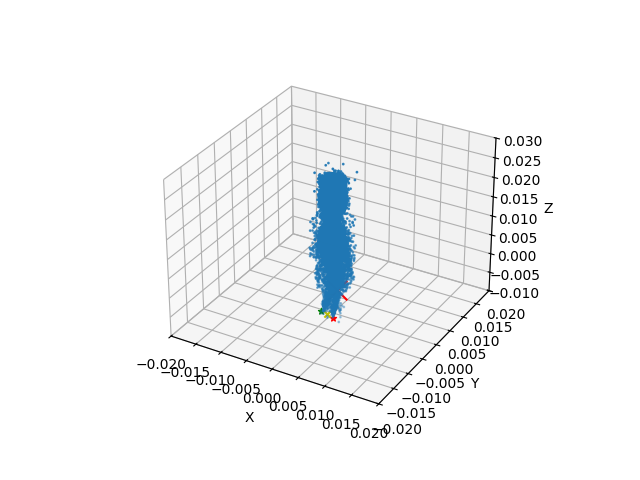

In [8]:
## plot the canonical gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.02, 0.02)
ax.set_ylim(-0.02, 0.02)
ax.set_zlim(-0.01, 0.03)
# ax.set_xlim(-0.035, 0.035)
# ax.set_ylim(-0.035, 0.035)
# ax.set_zlim(-0.51, -0.44)
ax.scatter(gaussians._xyz[:, 0].detach().cpu().numpy(), gaussians._xyz[:, 1].detach().cpu().numpy(), gaussians._xyz[:, 2].detach().cpu().numpy(), s=1)

# ## find the point with min z value and its index
min_z, min_z_idx = torch.min(gaussians._xyz[:, 2], 0)
print(min_z_idx)
ax.scatter(gaussians._xyz[min_z_idx, 0].detach().cpu().numpy(), gaussians._xyz[min_z_idx, 1].detach().cpu().numpy(), gaussians._xyz[min_z_idx, 2].detach().cpu().numpy(), s=20, c='r', marker='*')

# ## find the point with abs value of x < 0.0005 and z < -0.5 with min y value and its index
filtered_indices = torch.logical_and(gaussians._xyz[:, 0] < -0.003, gaussians._xyz[:, 2] < -0.005)
filtered_points = gaussians._xyz[filtered_indices]
print(filtered_points)
min_y, min_y_idx = torch.min(filtered_points[:, 1], 0)
original_min_y_idx = torch.nonzero(filtered_indices)[min_y_idx][0]
print(original_min_y_idx)
ax.scatter(gaussians._xyz[original_min_y_idx, 0].detach().cpu().numpy(), gaussians._xyz[original_min_y_idx, 1].detach().cpu().numpy(), gaussians._xyz[original_min_y_idx, 2].detach().cpu().numpy(), s=20, c='g', marker='*')

# ## find middle point between the two points
middle_point = (gaussians._xyz[min_z_idx] + gaussians._xyz[original_min_y_idx]) / 2
ax.scatter(middle_point[0].detach().cpu().numpy(), middle_point[1].detach().cpu().numpy(), middle_point[2].detach().cpu().numpy(), s=20, c='y', marker='x')

## find the point with x and y around 0 and z = 0.005
filtered_indices = torch.logical_and(torch.logical_and(torch.abs(gaussians._xyz[:, 0]) < 0.003, torch.abs(gaussians._xyz[:, 1]) < 0.003), torch.abs(gaussians._xyz[:, 2] + 0.005) < 0.001)
filtered_points = gaussians._xyz[filtered_indices]
print(filtered_points)
min_y, min_y_idx = torch.min(torch.abs(filtered_points[:, 0]), 0)
screw_point_idx = torch.nonzero(filtered_indices)[min_y_idx][0]
ax.scatter(gaussians._xyz[screw_point_idx, 0].detach().cpu().numpy(), gaussians._xyz[screw_point_idx, 1].detach().cpu().numpy(), gaussians._xyz[screw_point_idx, 2].detach().cpu().numpy(), s=200, c='r', marker='x')

plt.show()


['pitch', 'left_jaw', 'right_jaw']


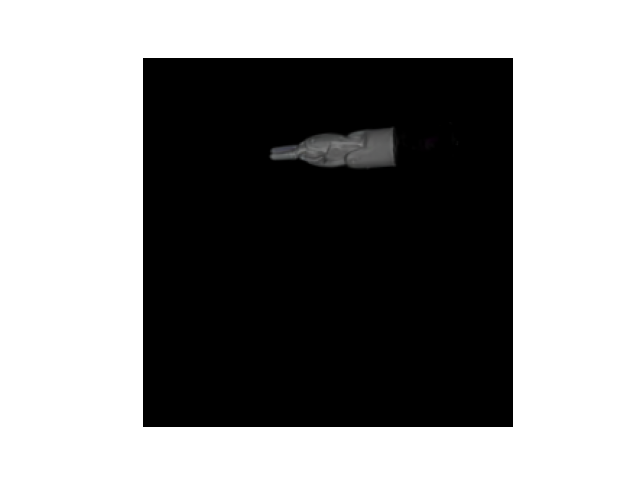

w2v: tensor([[ 7.7138e-02, -7.7028e-01,  6.3302e-01,  0.0000e+00],
        [-1.6173e-01, -6.3617e-01, -7.5441e-01,  0.0000e+00],
        [ 9.8382e-01, -4.4183e-02, -1.7365e-01,  0.0000e+00],
        [ 4.8338e-04, -1.9943e-02,  1.0000e-01,  1.0000e+00]],
       requires_grad=True)


In [9]:
## ------ Render Init Gaussian ------ ##
n = len(kinematic_chain.get_joint_parameter_names())  
print(kinematic_chain.get_joint_parameter_names())  
# home_pose = [0.2, 0.3, 0.222, -0.203, 0.257]
home_pose = [0.0, -0.0, -0.0]
# example_camera = sample_cameras[0]
# home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
example_camera.joint_pose = torch.tensor(home_pose,).requires_grad_(True)
example_camera.world_view_transform.requires_grad_(True)

# gaussians._xyz = torch.matmul(gaussians._xyz, R_z.T)  # Transpose R_z for proper multiplication
result = render(example_camera, gaussians, background_color)

# Use the raw alpha channel as a continuous mask
mask = result['render']  # Continuous alpha values, directly from render_alphas
pc = result['pc'].detach().cpu().numpy() # Point cloud, directly from render_points

fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_xlim(-0.02, 0.02)
# ax.set_ylim(-0.02, 0.02)
# ax.set_zlim(-0.01, 0.03)
# frame = mask  # Use the mask directly without clamping or thresholding

# ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)

# ax.scatter(pc[screw_point_idx, 0], pc[screw_point_idx, 1], pc[screw_point_idx, 2], s=200, c='r', marker='x')

# Display the mask (optional, normalized for visualization)
Utils.display_render(torch.clamp(mask, 0, 1))

print("w2v:", example_camera.world_view_transform)


### Optimization

In [10]:
## ------ Setting Optimization Parameters ------ ##

# Initialize parameters
joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")  # Initial joint pose
world_view_transform_result = example_camera.world_view_transform.clone().detach().to("cuda").requires_grad_(True) # Initial camera transform
print(joint_pose_result)
# print(world_view_transform_result)
# Define different learning rates
# joint_pose_lr = 2e-4
# world_transform_lr = 1e-4

joint_pose_lr = 5e-4
rotation_lr = 5e-4
# translation_lr = 1e-4
translation_lr = 3e-4
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# quat, translation = decompose_homogeneous_matrix_quaternion(example_camera.world_view_transform.clone().detach().cpu())
# quat = torch.nn.Parameter(quat, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# # Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": quat, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])

# rotation_result = example_camera.world_view_transform[:3, :3].clone().detach().to("cuda").requires_grad_(True)
# translation_result = example_camera.world_view_transform[3, :3].clone().detach().to("cuda").requires_grad_(True)

# print(rotation_result)
# print(translation_result)

# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": rotation_result, "lr": rotation_lr},
#     {"params": translation_result, "lr": translation_lr}
# ])

num_iterations = 100
from pytorch_msssim import ssim
def combined_loss(rendered, reference, alpha=0.8):
    mse = F.mse_loss(rendered, reference)
    
    # Ensure inputs are 4D: (batch, channels, height, width)
    rendered = rendered.unsqueeze(0) if rendered.dim() == 3 else rendered
    reference = reference.unsqueeze(0) if reference.dim() == 3 else reference
    
    ssim_l = 1 - ssim(rendered, reference, data_range=1.0)
    return alpha * ssim_l + (1 - alpha) * mse

loss_fn = combined_loss
# loss_fn = torch.nn.MSELoss()
video = []


tensor([0., -0., -0.], device='cuda:0', requires_grad=True)


100%|██████████| 100/100 [00:02<00:00, 34.61it/s]


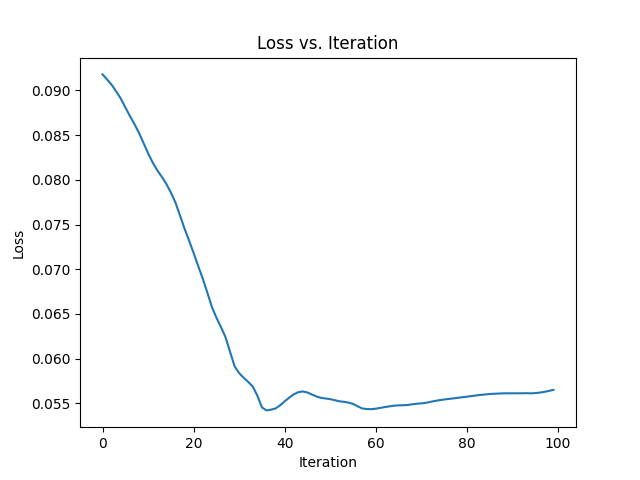

Difference between initial and final world_view_transform:
 tensor([[0.1062, 0.0282, 0.0596, 0.0000],
        [0.1477, 0.0508, 0.0562, 0.0000],
        [0.0009, 0.1847, 0.0551, 0.0000],
        [0.0018, 0.0105, 0.0113, 0.0000]], device='cuda:0',
       grad_fn=<AbsBackward0>)
Final joint pose: tensor([-0.0330, -0.0060,  0.0366], device='cuda:0', requires_grad=True)
Final camera transform: tensor([[ 0.1833, -0.7985,  0.5735,  0.0000],
        [-0.0141, -0.5854, -0.8106,  0.0000],
        [ 0.9830,  0.1405, -0.1185,  0.0000],
        [ 0.0023, -0.0094,  0.1113,  1.0000]], device='cuda:0',
       requires_grad=True)


In [11]:

fig = plt.figure()
# Optimization loop
# video, joint_pose_result, rotation_result, translation_result, pc, loss= Utils.optimization_w2v_rot(example_camera, gaussians, background_color, reference_image, 
#                                                                                                optimizer, joint_pose_result, rotation_result, translation_result, num_iterations, plot=True)
video, joint_pose_result, world_view_transform_result, pc, loss = Utils.optimization_w2v(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations, plot=True)
# video, joint_pose_result, world_view_transform_result, euler_angles_result, translation_result = optimization_quat(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)

# Final results
# world_view_transform_result = torch.eye(4, device="cuda")
# world_view_transform_result[:3, :3] = rotation_result
# world_view_transform_result[3, :3] = translation_result
print("Final joint pose:", joint_pose_result)
print("Final camera transform:", world_view_transform_result)


MoviePy - Building file pose_est_init.gif with imageio.


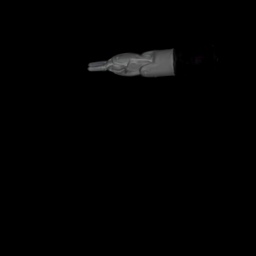

In [12]:
## ------ Save the video ------ ##
Utils.make_video(video, filename="pose_est_init", fps=10)
IPImage(filename="pose_est_init.gif")


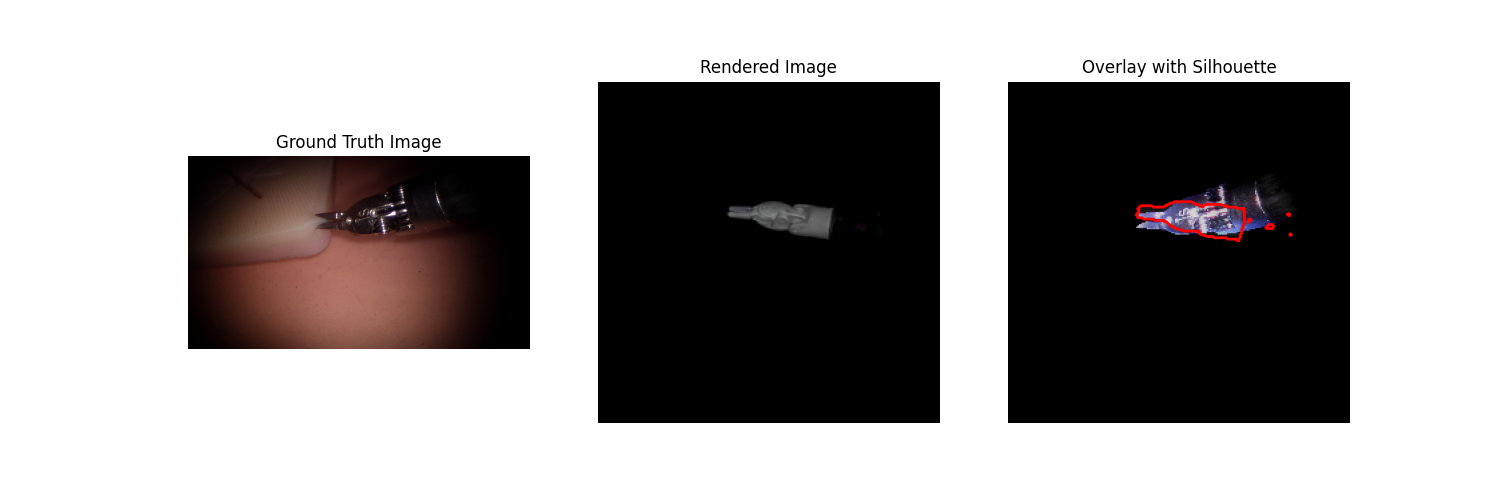

In [13]:


## ------ Compare the final rendered image and the reference image with overlay ------ ##
final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)
padded_rendered_image = Utils.pad_to_match_aspect(final_render, target_aspect_ratio)

# Convert images for visualization
# rendered_image_np = video[-1].detach().permute(1, 2, 0).cpu().numpy()
rendered_image_np = padded_rendered_image.detach().permute(1, 2, 0).cpu().numpy()
ground_truth_image_np = reference_image.permute(1, 2, 0).cpu().numpy()

# Alpha blending (overlay with transparency)
alpha = 0.3  # Transparency factor
blended_image = (alpha * rendered_image_np + (1 - alpha) * ground_truth_image_np)

# Extract silhouette using threshold and contour detection
rendered_mask = np.any(rendered_image_np > 0.05, axis=-1)  # Threshold for silhouette detection
contours = measure.find_contours(rendered_mask.astype(float), 0.5)

## Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Ground Truth
ax = axs[0]
ax.set_title("Ground Truth Image")
ax.imshow(original_image)
ax.axis('off')

# Mask (if required)
# ax = axs[1]
# ax.set_title("Original Mask")
# ax.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
# ax.axis('off')

# Rendered Image
ax = axs[1]
ax.set_title("Rendered Image")
ax.imshow(rendered_image_np)
ax.axis('off')

# Blended Visualization with Silhouette
ax = axs[2]
ax.set_title("Overlay with Silhouette")
ax.imshow(blended_image)

# Draw silhouette contours on the blended image
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('off')

# plt.tight_layout()
plt.show()


In [14]:
# ## ------ Iterate through the video ------ ##

# # Path to the folder containing images
# image_folder = "/home/iulian/chole_ws/data/lift_exp/lift_5/"
# # image_folder = "/home/iulian/chole_ws/data/atracsys_data/r_1/"

# # Count the number of files and prepare the image list
# imgs = []
# image_num = Utils.count_files(image_folder)
# for i in range(int(image_num)):
#     img_path = os.path.join(image_folder, f"image_{i:04d}.jpg")
#     img = Image.open(img_path)
#     # img = np.array(img)[:540, :540]

#     img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
#     img = Utils.pad_to_match_aspect(img, 1.0)
    
#     img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
#     imgs.append(img)

# # Check number of images
# print("Number of images:", len(imgs))

# Utils.make_video(imgs, filename="r_1")

# IPImage(filename="r_1.gif")

Number of images: 160
MoviePy - Building file lift_5.gif with imageio.


(-0.5, 255.5, 255.5, -0.5)

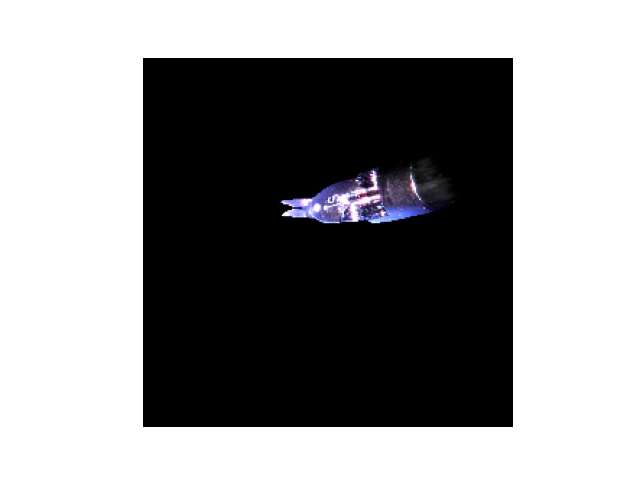

In [15]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/data/lift_exp/lift_5_segment_results/"

# Count the number of files and prepare the image list
imgs = []
image_num = Utils.count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"frame_{i}_id_1.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]
    img = FT.adjust_brightness(img, brightness_factor=4.1)  # Increase brightness by 20%
    img = FT.adjust_contrast(img, contrast_factor=1.2)    # Increase contrast by 50%
    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = Utils.pad_to_match_aspect(img, 1.0)
    
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

Utils.make_video(imgs, filename="lift_5")

# IPImage(filename="lift_5.gif")
fig = plt.figure()
plt.imshow(imgs[150].permute(1,2,0).detach().cpu().numpy())
plt.axis('off')

In [16]:

# ## read the csv file
# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/ee_csv.csv"
# ee_csv = pd.read_csv(ee_csv_path)
# header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
#                         "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
#                         "psm1_jaw"]

# header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
#                         "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
#                         "psm2_jaw"]

# ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
# ee_l_qpos_init = ee_l_qpos[0]
# ## normalize the data (substract with the initial pose)
# ee_l_qpos = ee_l_qpos - ee_l_qpos_init

# best_config, best_errors = optimize_and_tune(
#     example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
#     world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=10,
#     max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
# )

In [17]:
# Initialize parameters
joint_pose_results = []
world_view_transform_results = []
videos = []
euler_results = []
trans_results = []
pc_results = {}
# Optimization loop
num_iterations = 100
# Define different learning rates
# joint_pose_lr = 5e-4
# rotation_lr = 1
# translation_lr = 3e-5

joint_pose_lr = 8e-4
translation_lr = 5e-5
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
# euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": euler_angles, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
for n, img in enumerate(imgs):
    ## call the optimization function
    video, joint_pose_result, world_view_transform_result, pc = Utils.optimization_kalman(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, pc = Utils.optimization_w2v(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, euler_result, trans_result = optimization_quat(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)
    
    joint_pose_results.append(joint_pose_result.clone().detach())
    world_view_transform_results.append(world_view_transform_result.clone().detach())
    pc_results[n] = pc.detach().cpu().numpy()

    # euler_results.append(euler_result.clone().detach())
    # trans_results.append(trans_result.clone().detach())
    videos.append(video[-1])    # append the last frame of the video

# # Final results
# print("Final joint pose:", joint_pose_result)
# print("Final camera transform:", world_view_transform_result)


Early stopping at 79
Early stopping at 57
Early stopping at 77
Early stopping at 43
Early stopping at 16
Early stopping at 52
Early stopping at 42
Early stopping at 52
Early stopping at 41
Early stopping at 17
Early stopping at 45
Early stopping at 45
Early stopping at 58
Early stopping at 26
Early stopping at 46
Early stopping at 25
Early stopping at 74
Early stopping at 14
Early stopping at 24
Early stopping at 39
Early stopping at 29
Early stopping at 22
Early stopping at 30
Early stopping at 24
Early stopping at 57
Early stopping at 83
Early stopping at 55
Early stopping at 15
Early stopping at 80
Early stopping at 35
Early stopping at 24
Early stopping at 71
Early stopping at 49
Early stopping at 49
Early stopping at 40
Early stopping at 15
Early stopping at 28
Early stopping at 24
Early stopping at 44
Early stopping at 41
Early stopping at 15
Early stopping at 26


KeyboardInterrupt: 

In [ ]:
## ------ Save the video ------ ##
Utils.make_video(videos, "./eval/tracking_sequence_lift_5")
IPImage(filename="./eval/tracking_sequence_lift_5.gif")
# plt.figure()
# plt.imshow(videos[30].permute(1,2,0).detach().cpu().numpy())
# plt.axis('off')


In [ ]:
IPImage(filename="mask_r_1.gif")


In [ ]:
def make_video_overlay(video1, video2, filename, fps=30):
    video1 = Utils.process_video(video1)
    video2 = Utils.process_video(video2)
    video = []
    for i in range(len(video1)):
        overlay = cv2.addWeighted(video1[i], 0.5, video2[i], 0.8, 0)
        rendered_mask = np.any(video1[i] > 0.3, axis=-1)  # Threshold for silhouette detection
        contours = measure.find_contours(rendered_mask.astype(float), 0.95)
        # Draw the contours on the overlay
        for contour in contours:
            overlay[np.round(contour[:, 0]).astype(int), np.round(contour[:, 1]).astype(int)] = [255, 0, 0]

        video.append(overlay)


    clip = ImageSequenceClip(list(video), fps=fps)
    clip.write_gif(f"{filename}.gif")
    return video

video = make_video_overlay(videos, imgs, filename="tracking_sequence_overlay_r_1")
IPImage(filename="tracking_sequence_overlay_r_1.gif")
# fig = plt.figure()
# plt.imshow(video[100])

In [ ]:

def invert_T(T):
    R = T[..., :3, :3]
    t = T[..., :3, [-1]]
    R_inv = R.transpose(-2, -1)
    t_inv = - R_inv @ t
    T_inv = T.clone()
    T_inv[..., :3, :3] = R_inv
    T_inv[..., :3, [-1]] = t_inv
    return T_inv


trans_results = []
T_tc_list = []
T_tc_homogeneous_list = []
P = sample_cameras[2].projection_matrix

tool_poses = []
image_width = 256
image_height = 256
original_image_width = 960
original_image_height = 540
# original_image_width = 1920
# original_image_height = 1080



for n, w in enumerate(world_view_transform_results):

    ## calculate middle point
    middle_point = (pc_results[n][min_z_idx] + pc_results[n][original_min_y_idx]) / 2
    screw_point = pc_results[n][screw_point_idx]
    # print(screw_point)

    theta_z = - np.pi /2 
    R_z = torch.tensor([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z),  np.cos(theta_z), 0],
        [0,              0,             1]
    ], device='cuda:0')

    theta = joint_pose_result[0].item() - np.pi/2
    R_x = torch.tensor([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ], device='cuda:0')
    
    ori_rotation = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], device='cuda:0')

    middle_point_homogeneous = torch.cat([torch.tensor(screw_point, device='cuda:0'), torch.tensor([1.0], device='cuda:0')])
    T_wt_homogeneous = torch.eye(4, device='cuda:0')
    T_wt_homogeneous[:3, :3] = R_z

    T_wt_homogeneous[:3, 3] = middle_point_homogeneous[:3]

    T_wc = w  #.transpose(1, 0)

    # Inverse of the world to camera transformation matrix (to transform from world to camera)
    T_wc_inv = invert_T(T_wc.transpose(1, 0))
    # print("TWC inv\n", T_wc_inv)

    # Calculate the position of the surgical tool in the camera frame
    T_tc_homogeneous = T_wt_homogeneous.T @ T_wc


    projected_pose = P.T.detach().cpu() @ T_tc_homogeneous[3, :].detach().cpu()
    # print(projected_pose)
    # projected_pose = T_tc_homogeneous[:4].detach().cpu() @ P

    # Normalize by the homogeneous coordinate (w) to get 2D image coordinates

    x_2d = ((projected_pose[0] / projected_pose[2] + 1) * 0.5) * image_width
    y_2d = ((projected_pose[1] / projected_pose[2] + 1) * 0.5) * image_height
    # x_2d = (x_2d ) * image_width
    # y_2d = (y_2d ) * image_height
    tool_pose = (x_2d, y_2d)
    # Extract the position of the surgical tool in the camera frame (ignoring the homogeneous coordinate)
    # print(T_tc_homogeneous)
    T_tc_list.append(T_tc_homogeneous[3, :3].detach().cpu().numpy())
    # print(T_tc_homogeneous_real[:3].detach().cpu().numpy(), T_tc_homogeneous[:3].detach().cpu().numpy())
    T_tc_homogeneous_list.append(T_tc_homogeneous.clone().detach().cpu().numpy())
    tool_poses.append(tool_pose)



In [ ]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for T_tc in T_tc_list:
    ax.scatter(T_tc[0], T_tc[1], T_tc[2], c="r")
ax.view_init(180, 180)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title("Relative action trajectory") 
plt.show()

In [ ]:
t_results = []

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax.imshow(original_image)
tool_poses_init = tool_poses[0]
print(tool_poses_init[0], tool_poses_init[1])
scale = original_image_width/image_width
offset = (original_image_width - original_image_height) /2
starting_point = [tool_poses_init[0] * scale, tool_poses_init[1] * scale]
print(starting_point[0], starting_point[1] - offset)
# starting_point = [298.73125, 398.9125]
# starting_point = tool_poses_init
ax.imshow(original_image)
for num in range(len(tool_poses)):
    tool_pose_x = scale * (tool_poses[num][0])# - tool_poses_init[0]) + starting_point[0]
    tool_pose_y = scale * (tool_poses[num][1]) - offset # - tool_poses_init[1]) + starting_point[1]
    t_results.append([tool_pose_x, tool_pose_y])
    ax.scatter(tool_pose_x, tool_pose_y, c="b")

In [ ]:

# starting_point = tool_poses_init
# # starting_point = [30, 160]
# scale = 1
# tool_poses_init = tool_poses[0]

# # scale = 256/960
# fig = plt.figure(figsize=(10, 10))

# def display_render_traj(image_tensor: torch.Tensor, tool_poses: list = None):
#     pose_results = []
#     im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
#     im = (im * 255).astype(np.uint8)
#     plt.imshow(im)
#     for num in range(len(tool_poses)):
#         tool_pose_x = scale * (tool_poses[num][0] - tool_poses_init[0]) + starting_point[0]
#         tool_pose_y = scale * (tool_poses[num][1] - tool_poses_init[1]) + starting_point[1]
#         plt.scatter(tool_pose_x, tool_pose_y, c="b", s=10)
#         pose_results.append([tool_pose_x, tool_pose_y])
#     # plt.axis('off')
#     plt.show()
#     return pose_results


# pose_results = display_render_traj(videos[0], tool_poses)


In [ ]:
# # for num in range(len(tool_poses)):
# #     tool_pose_x = scale * (tool_poses[num][0] - tool_poses[0][0]) + starting_point[0]
# #     tool_pose_y = scale * (tool_poses[num][1] - tool_poses[0][1]) + starting_point[1]
# #     pose_results.append([tool_pose_x, tool_pose_y])

# def display_render_traj_frame(image_tensor: torch.Tensor, pose_results: list):
#     im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
#     im = (im * 255).astype(np.uint8)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.imshow(im)
#     # Plot the trajectory
#     for n in range(len(pose_results)):
#         tool_pose_x = pose_results[n][0]
#         tool_pose_y = pose_results[n][1]
#         ax.scatter(tool_pose_x, tool_pose_y, c="r", s=10)
#     plt.axis('off')
#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     plt.close(fig)
#     return image

# # Generate the GIF frames
# frames = []
# for frame_tensor in videos:
#     frame = display_render_traj_frame(frame_tensor, pose_results)
#     frames.append(frame)

# # Save the GIF
# filename = "./trajectory_render"
# clip = ImageSequenceClip(list(frames), fps=30)
# clip.write_gif(f"{filename}.gif")
# print(f"GIF saved at: {filename}")

In [ ]:
# quaternion to rotation matrix
def quaternion_to_rotation_matrix(quaternion):
    """
    Convert a quaternion to a rotation matrix.

    Args:
        quaternion: A list containing the quaternion [x, y, z, w].

    Returns:
        A 3x3 rotation matrix.
    """
    x, y, z, w = quaternion
    rotation_matrix = np.array([
        [1 - 2 * y**2 - 2 * z**2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x**2 - 2 * z**2, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x**2 - 2 * y**2]
    ])
    return rotation_matrix

## read the csv file
ee_csv_path = "/home/iulian/chole_ws/data/lift_exp/lift_5/ee_csv.csv"
# ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1_cp.csv"
# ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1.csv"

# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/grab/ee_csv.csv"
ee_csv = pd.read_csv(ee_csv_path)
header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
                        "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
                        "psm1_jaw"]

header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
                        "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
                        "psm2_jaw"]

ee_l_qpos = ee_csv[header_name_qpos_psm1].to_numpy()

# ee_l_qpos = ee_csv.to_numpy()

ee_l_qpos_init = ee_l_qpos[0]
R_ee_init = quaternion_to_rotation_matrix(ee_l_qpos[0][3:7])
T_ee_init = ee_l_qpos[0][:3]
H_ee_init = np.eye(4)
H_ee_init[:3, :3] = R_ee_init
H_ee_init[:3, 3] = T_ee_init
# print(H_ee_init)
euler  = Rotation.from_quat(ee_l_qpos[0][3:7]).as_euler('zyx', degrees=True)
print(euler)
## calculate the relative action trajectory against the first frame of the ground truth trajectory
relative_action = []
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# for r in ee_l_qpos:
#     H_ee = np.eye(4)
#     H_ee[:3, 3] = r[:3]
#     H_ee[:3, :3] = quaternion_to_rotation_matrix(r[3:7])
#     # print(H_ee)
#     H_ee_relative = np.linalg.inv(H_ee_init) @ H_ee
#     relative_action.append(H_ee_relative)
#     # print(H_ee_relative[:3, 3])
#     ax.scatter(H_ee_relative[0, 3], H_ee_relative[1, 3], H_ee_relative[2, 3], c="r")
theta = -np.pi/2   # Example: 45-degree rotation
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0, 0],
    [np.sin(theta),  np.cos(theta), 0, 0],
    [0,              0,             1, 0],
    [0,              0,             0, 1]
])
theta_1 = np.pi /2   # Example: 45-degree rotation

R_x = np.array([
    [1, 0, 0, 0],
    [0, np.cos(theta_1), -np.sin(theta_1), 0],
    [0, np.sin(theta_1), np.cos(theta_1), 0],
    [0, 0, 0, 1]
])
theta = np.pi/2   # Example: 45-degree rotation

R_z_2 = np.array([
    [np.cos(theta), -np.sin(theta), 0, 0],
    [np.sin(theta),  np.cos(theta), 0, 0],
    [0,              0,             1, 0],
    [0,              0,             0, 1]
])
theta = np.pi   # Example: 45-degree rotation
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])
results = []


H_tc_init = T_tc_homogeneous_list[0].T
print(H_tc_init)
euler_tc = Rotation.from_matrix(H_tc_init[:3, :3]).as_euler('zyx', degrees=True)
print(euler_tc)
count = 0
scale = 256/540
H_result = []
count = 0
for H_est in T_tc_homogeneous_list:
    H_est_relative = np.linalg.inv(H_tc_init) @ H_est.T
    # H_est_relative[:3, 3] = scale * H_est_relative[:3, 3]
    # print(H_est_relative[:3, 3])
    # print(H_est_relative)
    # res = scale * (r - T_tc_list[0])
    res = H_est_relative
    T_relative = scale * (T_tc_list[count] - T_tc_list[0])
    res[:3, 3] = R_z @ T_relative
    results.append([res[0, 3], res[1, 3], res[2, 3]])
    H_result.append(res)
    count += 1

results = np.array(results)  # Convert list to NumPy array

ax.scatter(results[:, 0], results[:, 1], results[:, 2], c="b", label="estimated")

    # count += 1
    # if count>50: 
        # break
# # plt.show()
# ax = fig.add_subplot(121, projection='3d')
ee_l_qpos_relative = ee_l_qpos - ee_l_qpos_init


print(H_result[-1][:3, :3] @ R_ee_init)


print(H_result[-1][:3, 3] + T_ee_init)

ax.scatter(ee_l_qpos_relative[:, 0], ee_l_qpos_relative[:, 1], ee_l_qpos_relative[:, 2], c="r", label="forward kinematics")

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_xlim(-0.005, 0.015)
ax.set_ylim(-0.01, 0.01)
ax.set_zlim(-0.01, 0.01)
## look from the top
ax.view_init(-90, 60)
ax.legend(fontsize=12)
# ax.view_init(0, 0)
## set title
# plt.title("relative action trajectory", fontsize=16)
# ax.legend(["robot", "human"])
plt.show()
print(results)
print(H_result[3][:3, 3])


In [ ]:
## calculate translation error
def calculate_translation_error(H_result, ee_l_qpos):
    translation_error = []
    for i in range(len(H_result)):
        translation_error.append(np.linalg.norm(H_result[i][:3, 3] - ee_l_qpos_relative[i][:3]))
    return translation_error

translation_error = calculate_translation_error(H_result, ee_l_qpos)

fig = plt.figure()
plt.plot(translation_error)
plt.xlabel("frame")
plt.ylabel("translation error (m)")
plt.title("Translation error")
plt.show()


In [ ]:
## calculate rotation error
def calculate_rotation_error(H_result, ee_l_qpos):
    rotation_error = []
    for i in range(len(H_result)):
        R = H_result[i][:3, :3]
        R_gt = quaternion_to_rotation_matrix(ee_l_qpos[i][3:7])
        rotation_error.append(np.linalg.norm(R - R_gt))
    return rotation_error

In [ ]:
# # quaternion to rotation matrix
# def quaternion_to_rotation_matrix(quaternion):
#     """
#     Convert a quaternion to a rotation matrix.

#     Args:
#         quaternion: A list containing the quaternion [x, y, z, w].

#     Returns:
#         A 3x3 rotation matrix.
#     """
#     x, y, z, w = quaternion
#     rotation_matrix = np.array([
#         [1 - 2 * y**2 - 2 * z**2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
#         [2 * x * y + 2 * z * w, 1 - 2 * x**2 - 2 * z**2, 2 * y * z - 2 * x * w],
#         [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x**2 - 2 * y**2]
#     ])
#     return rotation_matrix

# ## read the csv file
# ee_csv_path = "/home/iulian/chole_ws/data/lift_exp/lift_5/ee_csv.csv"
# # ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1_cp.csv"
# # ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1.csv"

# # ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/grab/ee_csv.csv"
# ee_csv = pd.read_csv(ee_csv_path)
# header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
#                         "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
#                         "psm1_jaw"]

# header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
#                         "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
#                         "psm2_jaw"]

# ee_l_qpos = ee_csv[header_name_qpos_psm1].to_numpy()

# # ee_l_qpos = ee_csv.to_numpy()


# ## ee_l_qpos is the ground truth trajectory format [x, y, z, qx, qy, qz, qw]
# # print(ee_l_qpos[0])
# # print(T_tc_list[0])

# ee_l_qpos_init = ee_l_qpos[0]

# theta = np.pi   # Example: 45-degree rotation
# R_z = np.array([
#     [np.cos(theta), -np.sin(theta), 0],
#     [np.sin(theta),  np.cos(theta), 0],
#     [0,              0,             1]
# ])
# theta_1 = np.pi /2   # Example: 45-degree rotation

# R_x = np.array([
#     [1, 0, 0],
#     [0, np.cos(theta_1), -np.sin(theta_1)],
#     [0, np.sin(theta_1), np.cos(theta_1)]
# ])


# ee_l_qpos_relative = ee_l_qpos - ee_l_qpos_init
# results = []
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# trans_init = [T_tc_list[0][0], T_tc_list[0][1] , T_tc_list[0][2]]
# print(ee_l_qpos_init[:3])
# # print(trans_init)
# # print(T_tc_list[0])
# # print(T_tc_list - T_tc_list[0])

# count = 0
# scale = 256/540
# for r in T_tc_list:
#     res = scale * (r - T_tc_list[0])
#     res = R_z @ res 
#     results.append([res[0], res[1], res[2]])
#     ax.scatter(res[0], res[1], res[2], c="b")
#     # count += 1
#     # if count>50: 
#         # break
# # # plt.show()
# # ax = fig.add_subplot(121, projection='3d')
# ax.scatter(ee_l_qpos_relative[:, 0], ee_l_qpos_relative[:, 1], ee_l_qpos_relative[:, 2], c="r")
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ## look from the top
# ax.view_init(-90, 90)
# # ax.view_init(0, 0)
# ## set title
# plt.title("relative action trajectory")
# # ax.legend(["robot", "human"])
# plt.show()
# # print(results)

In [ ]:
## ------ Save the results to csv file ------ ##
csv_result = []

for r in H_result:
    translation_result = r[:3, 3]
    rotation_results = r[:3, :3].reshape(-1)
    csv_result.append(np.concatenate([translation_result, rotation_results]))



## write the results to csv file
results = pd.DataFrame(csv_result, columns=["tx", "ty", "tz", "r11", "r12", "r13", "r21", "r22", "r23", "r31", "r32", "r33"])



results.to_csv("results_lift.csv", index=False)

In [ ]:
# def quaternion_to_rotation_matrix(quaternion):
#     """
#     Convert a quaternion to a rotation matrix.

#     Args:
#         quaternion: A list containing the quaternion [x, y, z, w].

#     Returns:
#         A 3x3 rotation matrix.
#     """
#     x, y, z, w = quaternion
#     rotation_matrix = np.array([
#         [1 - 2 * y**2 - 2 * z**2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
#         [2 * x * y + 2 * z * w, 1 - 2 * x**2 - 2 * z**2, 2 * y * z - 2 * x * w],
#         [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x**2 - 2 * y**2]
#     ])
#     return rotation_matrix
# def estimate_transformation(pts_gt, pts_est):
#     """
#     Estimate the rigid transformation (R, t) that aligns pts_est to pts_gt.
    
#     Args:
#         pts_gt:  (N, 3) array of ground truth 3D points.
#         pts_est: (N, 3) array of estimated 3D points.

#     Returns:
#         R (3x3 rotation matrix), t (3x1 translation vector)
#     """
#     # Compute centroids
#     centroid_gt = np.mean(pts_gt, axis=0)
#     centroid_est = np.mean(pts_est, axis=0)
    
#     # Center the points
#     P_prime = pts_gt - centroid_gt
#     Q_prime = pts_est - centroid_est
    
#     # Compute the covariance matrix
#     H = Q_prime.T @ P_prime
    
#     # Compute SVD
#     U, S, Vt = np.linalg.svd(H)
    
#     # Compute rotation
#     R = Vt.T @ U.T
    
#     # Ensure proper rotation (det(R) should be 1, not -1)
#     if np.linalg.det(R) < 0:
#         Vt[-1, :] *= -1
#         R = Vt.T @ U.T
    
#     # Compute translation
#     t = centroid_gt - R @ centroid_est
    
#     return R, t

In [ ]:

# # plt.close('all')
# # import time
# # time.sleep(1)
# # quaternion to rotation matrix

# ## read the csv file
# ee_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1_cp.csv"

# atracsys_csv_path = "/home/iulian/chole_ws/data/atracsys_data/pose_csv/mark_r_1.csv"


# # ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/grab/ee_csv.csv"
# ee_csv = pd.read_csv(ee_csv_path)
# atracsys_csv = pd.read_csv(atracsys_csv_path)
# ee_l_qpos = ee_csv.to_numpy()
# atracsys_pos = atracsys_csv.to_numpy()
# ## homogeneous transformation matrix for the first frame
# # convert quaternion to rotation matrix
# R_ee_init = quaternion_to_rotation_matrix(ee_l_qpos[0][3:])
# T_ee_init = ee_l_qpos[0][:3]
# H_ee_init = np.eye(4)
# H_ee_init[:3, :3] = R_ee_init
# H_ee_init[:3, 3] = T_ee_init
# # print(H_ee_init)

# ## calculate the relative action trajectory against the first frame of the ground truth trajectory

# # print(relative_action[0][:3, 3])

# def invert_H(H):
#     R = H[:3, :3]
#     t = H[:3, 3]
#     R_inv = R.transpose()
#     t_inv = - R_inv @ t
#     H_inv = np.eye(4)
#     H_inv[:3, :3] = R_inv
#     H_inv[:3, 3] = t_inv
#     return H_inv

# relative_action = []


# ## calculate the relative action trajectory against the first frame of the estimated trajectory
# relative_action_est = []
# # fig = plt.figure(figsize=(10, 10))
# # ax = fig.add_subplot(111, projection='3d')
# H_tc_init = np.eye(4)
# R_tc_init = quaternion_to_rotation_matrix(atracsys_pos[0][3:])

# H_tc_init[:3, 3] = atracsys_pos[0][:3]
# H_tc_init[:3, :3] = R_tc_init

# # print(H_tc_init)
# # R_z = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
# theta = -np.pi /2   # Example: 45-degree rotation
# R_z = np.array([
#     [np.cos(theta), -np.sin(theta), 0],
#     [np.sin(theta),  np.cos(theta), 0],
#     [0,              0,             1]
# ])
# theta_1 = -np.pi/2.5   # Example: 45-degree rotation

# R_x = np.array([
#     [1, 0, 0],
#     [0, np.cos(theta_1), -np.sin(theta_1)],
#     [0, np.sin(theta_1), np.cos(theta_1)]
# ])


# # H_tc_init[:3, :3] = R_x
# # H_tc_init[:3, :3] = R_z @ R_x
# # H_tc_init[:3, :3] = R_y @ R_x @ R_z
# ## apply rotation to z axis for the first frame
# # H_tc_init[:3, :3] = np.array([[0,1, 0], [-1, 0, 0], [0, 0, 1]])



# # print(H_tc_init)
# # H_cam_atracsys = H_tc_init @ invert_H(H_ee_init) 
# R, t = estimate_transformation(atracsys_pos[:, :3], ee_l_qpos[:, :3])
# print(R, t)

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# for r in atracsys_pos:
#     H_est = np.eye(4)
#     H_est[:3, 3] = r[:3]
#     # H_est[:3, :3] = np.array([[0,-1, 0], [1, 0, 0], [0, 0, 1]])

#     H_est[:3, :3] = np.eye(3)
#     # print(H_est)
#     H_est_relative = H_est
#     # H_est_relative = np.linalg.inv(H_tc_init) @ H_est
#     relative_action_est.append(H_est_relative)
#     # print(H_est_relative[:3, 3])
#     ax.scatter(H_est_relative[0, 3], H_est_relative[1, 3], H_est_relative[2, 3], c="b")

# for r in ee_l_qpos:
#     H_ee = np.eye(4)
#     H_ee[:3, 3] = r[:3]
#     H_ee[:3, :3] = quaternion_to_rotation_matrix(r[3:])
#     # print(H_ee)
#     # H_corrected =  H_ee
#     H_ee_relative = (R @ H_ee[:3,3].T).T + t
#     # H_ee_relative = invert_H(H_ee_init) @ H_ee
#     relative_action.append(H_ee_relative)
#     # print(H_ee_relative)
#     ax.scatter(H_ee_relative[0], H_ee_relative[1], H_ee_relative[2], c="r")
#     # ax.scatter(H_ee_relative[0, 3], H_ee_relative[1, 3], H_ee_relative[2, 3], c="r")
# print("ee:", H_ee_relative)
# H_render_init = np.eye(4)
# H_render_init[:3, 3] = T_tc_list[0][:3, 3]
# H_render_init[:3, :3] = T_tc_list[0][:3, :3]

# for r in T_tc_list:
#     H_render = np.eye(4)
#     H_render[:3, 3] = r[:3, 3]
#     H_render[:3, :3] = r[:3, :3]
#     # H_est[:3, :3] = np.array([[0,-1, 0], [1, 0, 0], [0, 0, 1]])

#     # H_render[:3, :3] = np.eye(3)
#     # print(H_est)
#     H_render_relative = np.linalg.inv(H_render_init) @ H_render 

#     H_render_relative =  ((R @ H_render_relative[:3,3].T).T + t)
#     relative_action_est.append(H_est_relative)
#     # print(H_est_relative[:3, 3])
#     ax.scatter(H_render_relative[0], H_render_relative[1], H_render_relative[2], c="g")

# print("render",H_render_relative)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# # ax.set_xlim(0, 0.04)
# # ax.set_ylim(-0.02, 0.02)
# # ax.set_zlim(-0.03, 0.01)
# # ax.view_init(90, 90)
# plt.title("Relative action trajectory")

# plt.show()



In [ ]:
# ## project the 3d points to 2d image
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# ax.imshow(original_image)
# # Set up rasterization configuration
# tanfovx = math.tan(example_camera.FoVx * 0.5)
# tanfovy = math.tan(example_camera.FoVy * 0.5)

# focal_length_x = example_camera.image_width / (2 * tanfovx)
# focal_length_y = example_camera.image_height / (2 * tanfovy)
# K = torch.tensor(
#     [
#         [focal_length_x, 0, example_camera.image_width / 2.0, 0],
#         [0, focal_length_y, example_camera.image_height / 2.0, 0],
#         [0, 0, 1, 0],
#         [0, 0, 0, 1],
#     ],
#     device="cuda",
# )

# ## use projection matrix to project the 3d points to 2d image
# # P = K.inverse()
# P = sample_cameras[3].projection_matrix
# # P[0,2] = 0
# # P[1,2] = 0
# # P[2,0] = original_image_width / 2
# # P[2,1] = original_image_height / 2
# print(P.T)
# ee_projected = []
# scale = 960/256
# ee_l_qpos_transform = ee_l_qpos
# for n in range(len(ee_l_qpos)):

#     T_ee_homogeneous = torch.cat([torch.tensor(ee_l_qpos_transform[n][:3], device='cuda:0'), torch.tensor([1.0], device='cuda:0')])
#     print(T_ee_homogeneous)
#     # print(ee_l_qpos_transform[n][:3])
#     projected_pose = P.T.detach().cpu().numpy() @ T_ee_homogeneous[:4].detach().cpu().numpy()
#     x_2d = ((projected_pose[0] / projected_pose[2] + 1) * 0.5) * original_image_width
#     y_2d = ((projected_pose[1] / projected_pose[2] + 1) * 0.5) * original_image_width
#     ee_projected.append([x_2d, y_2d])
#     ax.scatter(x_2d, y_2d, c="b")
#     ax.scatter(t_results[n][0], t_results[n][1], c="r")



In [ ]:
# ## plot error between the estimation and the ground truth
# errors = []

# n = 2
# for i in range(len(ee_l_qpos)):
#     error = np.linalg.norm(ee_l_qpos[i, :n] - results[i][:n])

#     errors.append(error)

# # print(np.linalg.norm(ee_l_qpos[:, :n], axis=1))
# fig = plt.figure()
# plt.plot(errors)
# # plt.plot(np.linalg.norm(ee_l_qpos[:, :n], axis=1), 'r')
# plt.xlabel("frame")
# plt.ylabel("error (m)")
# plt.ylim(0, 0.01)
# plt.title("Error (norm) between the estimated and the ground truth")
# plt.show()

